In [86]:
import numpy as np
import matplotlib.pyplot as plt
import random
import scipy.ndimage as scp

def makeGaussian(size, fwhm = 3, center=None):
    """ Make a square gaussian kernel.

    size is the length of a side of the square
    fwhm is full-width-half-maximum, which
    can be thought of as an effective radius.
    """

    x = np.arange(0, size, 1, float)
    y = x[:,np.newaxis]

    if center is None:
        x0 = y0 = size // 2
    else:
        x0 = center[0]
        y0 = center[1]

    return np.exp(-4*np.log(2) * ((x-x0)**2 + (y-y0)**2) / fwhm**2)



In [458]:
def generate_background(x_dim, y_dim):
    my_dpi = 100
    arr = np.zeros((x_dim,y_dim))
    for i in range(20000):
        x=random.randint(0-10,x_dim+10)
        y=random.randint(0-10,x_dim+10)
        
        fwhm=10
        arr=arr+makeGaussian(x_dim,fwhm=fwhm,center=[x,y])
    """
    for i in range(1000):
        xy = np.where(arr == np.min(arr))
        r=20
        x=xy[1]+random.randint(-r,r)
        y=xy[0]+random.randint(-r,r)
        fwhm=10
        arr=arr+makeGaussian(x_dim,fwhm=fwhm,center=[x,y])
    #arr=np.log(arr)
    """
    arr = np.abs(arr - np.min(arr))/np.max(arr)
    
    #arr = np.where(arr<0.1,arr+random.random()*1/arr,arr)
    #print(arr)
    return arr
    


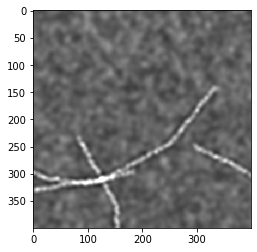

In [457]:
from scipy import interpolate
def generate_signal(arr,points_x=None,points_y=None,nr_lines=4):
    arr_s = np.zeros_like(arr)
    x_dim, y_dim = arr.shape

    if points_x==None and points_y==None:
        length=random.randint(50,150)
        theta = random.random()*2*np.pi
        d_theta=0.5
        start_x = random.randint(50,x_dim-50)
        start_y = random.randint(50,y_dim-50)
        x=np.array([])
        y=np.array([])
        for i in range(nr_lines):
            theta=theta+random.random()*d_theta
            end_x = start_x + np.cos(theta)*length
            end_y = start_y + np.sin(theta)*length
            f = interpolate.interp1d([start_x,end_x], [start_y,end_y],kind="slinear")
            xnew = np.linspace(start_x, end_x, length)
            ynew = f(xnew)
            x=np.append(x,xnew)
            y=np.append(y,ynew)
            start_x=end_x
            start_y=end_y


    for x1,y1 in zip(x,y):
        y_n = int(y1+random.randint(-3,3))
        x_n = int(x1+random.randint(-3,3))
        
        arr_s=arr_s+1.3*makeGaussian(x_dim,fwhm=9,center=[x_n,y_n])-makeGaussian(x_dim,fwhm=10,center=[x_n,y_n])
    arr_s = arr_s/np.max(arr_s)
    return arr_s





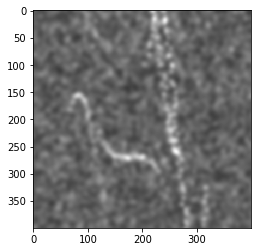

In [400]:
from scipy import interpolate
def generate_signal_junk(arr,points_x=None,points_y=None,nr_points=4):
    arr_s = np.zeros_like(arr)
    x_dim, y_dim = arr.shape
    if points_x==None and points_y==None:
        signal_length=random.randint(150,300)
        start_x = random.randint(0,x_dim-signal_length)
        start_y = random.randint(0,y_dim-signal_length)
        points_x = np.unique(np.random.randint(start_x, start_x+signal_length,size=nr_points), axis=0)
        #points_x = np.sort(points_x)
        #points_y = np.unique(np.random.randint(start_y, start_y+signal_length,size=nr_points), axis=0)
        points_y = np.random.randint(start_y, start_y+signal_length,size=len(points_x))
        points_y = np.sort(points_y)
    f = interpolate.interp1d(points_x, points_y,kind="cubic")
    xnew = np.arange(points_x[0], points_x[-1], 1)
    ynew = f(xnew)

    for x,y in zip(xnew,ynew):
        y_n = int(y+random.randint(-4,4))
        x_n = int(x+random.randint(-4,4))
        
        arr_s=arr_s+makeGaussian(x_dim,fwhm=10,center=[x_n,y_n])
    arr_s = np.abs(arr_s - np.min(arr_s))/np.max(arr_s)
    return arr_s



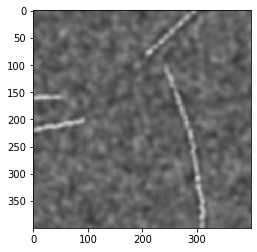

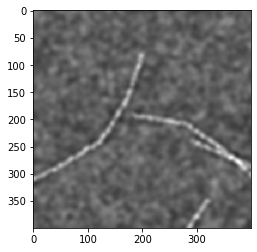

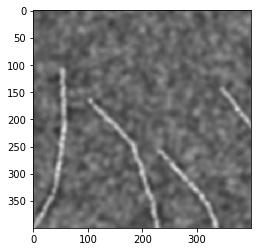

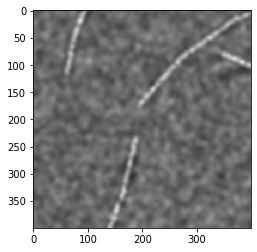

In [459]:

for i in range(4):
    arr=generate_background(400,400)
    for i in range(4):
        arr =arr + generate_signal(arr=arr)
    arr = scp.gaussian_filter(arr,2)
    plt.imshow(arr, interpolation='none',cmap="gray",vmin=-0.4,vmax=1.5)
    plt.show()
